# Imports and general definitions

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
path = Path.cwd() / 'export_files'

#define min and max risk score (0 = low risk, 100 = high risk):
min_risk, max_risk = 0.0, 100.0

#define weights for each risk dimension:
weights = {
    'Geopolitical': 0.2,
    'Dependency': 0.3,
    'Size': 0.3,
    'Compliance': 0.2}

#Map country codes from format in addresses to format in indices:
country_codes = {
    'china': 'CHN',
    'israel': 'ISR',
    'germany': 'DEU',
    'sweden': 'SWE',
    'switzerland': 'CHE'}


# Support Functions

In [2]:
#Function to remove excess quotation marks 
def clean_id(s):
    return (
        s.astype(str)
         .str.replace('"', "")
         .str.strip())

# Load Data and Transform

In [3]:
#Load Data into data frames
addresses = pd.read_csv(path / 'addresses.csv')
articles = pd.read_csv(path / 'articles.csv')
indices = pd.read_csv(path / 'indices.csv')
orders = pd.read_csv(path / 'orders.csv')
suppliers = pd.read_csv(path / 'suppliers.csv')

#Make all non-numeric ID's numeric for merging using above helper function:
orders['supplier_id'] = pd.to_numeric(clean_id(orders["supplier_id"]), errors="coerce").astype("Int64")
articles['Article_ID']   = pd.to_numeric(clean_id(articles["Article_ID"]),   errors="coerce").astype("Int64")
orders["article_id"]   = pd.to_numeric(clean_id(orders["article_id"]), errors="coerce").astype("Int64")
addresses["supplier_id"] = pd.to_numeric(clean_id(addresses["supplier_id"]), errors="coerce").astype("Int64")
suppliers["supplier_id"] = pd.to_numeric(clean_id(suppliers["supplier_id"]), errors="coerce").astype("Int64")

#Make all strings small cap:
articles['Industry'] = articles['Industry'].str.lower()
addresses['country'] = addresses['country'].str.lower()

#Map country names to iso codes
addresses['country'] = addresses['country'].map(country_codes)

#Get unique suppliers, assumption: only one country per supplier (assumed country of origin)!
#Checked that duplicated supplier_id are the same in all other characterisitics (same revenue, certificates etc.)
addresses = addresses.groupby(by = 'supplier_id', as_index = False).agg(country = ('country', 'first'))
suppliers = suppliers[suppliers['status'] == 'active']
suppliers = suppliers.drop_duplicates('supplier_id')


# Set up Master output table

In [4]:
#Prepare basic information for output table
country = addresses[['supplier_id', 'country']].groupby(by = 'supplier_id', as_index = False).agg(country = ('country', 'first'))
order_value = orders.groupby(by = 'supplier_id', as_index = False).agg(total_order_value=("order_value", "sum"))
industry = (orders.merge(articles, left_on = 'article_id', right_on = 'Article_ID')
            .groupby(by = 'supplier_id', as_index = False)
            .agg(industry = ('Industry', 'first'))) #assumption: only one industry per supplier!

#Merge above info into supplier master table
supplier_master = (
    country.merge(order_value, on = "supplier_id")
    .merge(industry, on = 'supplier_id'))

# sanity check: total order values match
assert supplier_master["total_order_value"].sum() == orders["order_value"].sum(), (
    'Sanity check failed, total_order_value in supplier_master does not match sum of order_value in orders table!')


# Prepare Risk Dimensions
## Geopolitical Dimension

In [5]:
#Merge indices and addresses on country ISO code (which was at the beginning)
geopolitical = indices.merge(addresses, left_on = 'country_id', right_on = 'country')

#Geopolitical score = 50/50 between HMI and environmental risk index
geopolitical['geo_score'] = (geopolitical['human_rights_index'] + geopolitical['enivronmental_risk'])/2

#Keep relevant columns
geopolitical = geopolitical[['supplier_id', 'geo_score']]

## Dependence Dimension

In [6]:
#I evaluate the share of each supplier in the total order volume + the no. of distinct articles they supply
#Single sourcing exposure was checked, but neglected as a criterion since min. no. of suppliers per article is 11
total_order_vol = orders["order_value"].sum()

#share of each supplier in total order volume:
dependence = orders.groupby(by = 'supplier_id', as_index = False).agg(total_order_value = ('order_value', 'sum'))
dependence['total_order_value_share'] = dependence['total_order_value'] / total_order_vol

#no. of different articles, each supplier supplies:
sup_per_article = (
    orders.groupby("supplier_id")["article_id"]
          .nunique()
          .rename("n_articles_per_supplier")
          .reset_index())

#putting the 2 parts together
dependence = dependence.merge(sup_per_article, on = 'supplier_id')[['supplier_id','total_order_value_share', 'n_articles_per_supplier']]

# Spend Share Score: if share = 10% --> score is 100, if share is 0,0% --> score is 0
low = 0.00
high = 0.1
dependence["spend_score"] = (
    np.clip(((dependence["total_order_value_share"]-low) / (high-low)), 0, 1) * 100)

# Article span score if span = 11 --> score is 100, if span is 0 --> score is 0
low = 0
high = articles['Article_ID'].nunique()
dependence["article_score"] = (
    np.clip(((dependence["n_articles_per_supplier"]-low) / (high-low)),0,1) * 100)

#Combine into total dependence score: 70% weight to spend share, 30% weight to article share
dependence['dependence_score'] = (dependence["spend_score"]*0.7 + dependence["article_score"]*0.3)

#sanity check: total of shares = 100%
assert np.isclose(dependence["total_order_value_share"].sum(), 1.0, rtol=1e-6), (
    'total sum of % shares is not equal to 1!')

#Only keep relevant columns
dependence = dependence[['supplier_id', 'dependence_score']]

## Supplier Size Dimension

In [7]:
supplier_size = suppliers.copy()

# Supplier Size Score: use log since differences for small revenues are more important than for large revenues
# Whether a supplier makes 5m or 50m revenue is much more important than whether a supplier makes 950m or 1bn
low = 10000000
high = 1000000000
supplier_size["size_score"] = (
    (np.log(high) - np.log(supplier_size["total_company_revenue"])) /
    (np.log(high) - np.log(low)) * 100
).clip(lower=0, upper=100)

#Only keep relevant columns:
supplier_size = supplier_size[['supplier_id', 'size_score']]

## Compliance Dimension

In [8]:
compliance = suppliers.copy()
compliance_map = {"yes": 10, "no": 90}

compliance["compliance_score"] = compliance["certificates_valid"].map(compliance_map).astype(int)

compliance = compliance[['supplier_id', 'compliance_score']]

# Merge all dimensions into Master Table

In [9]:
#merge individual tables into final table:
final_table = (supplier_master
                    .merge(geopolitical, on = 'supplier_id', how = 'left', validate = 'one_to_one')
                   .merge(dependence, on = 'supplier_id', how = 'left', validate = 'one_to_one')
                   .merge(supplier_size, on = 'supplier_id', how = 'left', validate = 'one_to_one')
                   .merge(compliance, on = 'supplier_id', how = 'left', validate = 'one_to_one'))

#Calculate final weighted risk score:
final_table['final_risk_score'] = (final_table['geo_score']* weights.get('Geopolitical')
                                       + final_table['dependence_score'] * weights.get('Dependency')
                                       + final_table['size_score'] * weights.get('Size')
                                       + final_table['compliance_score'] * weights.get('Compliance'))

#Sort by risk score to show most risky suppliers first:
final_table.sort_values(by = 'final_risk_score', ascending = False)

,supplier_id,country,total_order_value,industry,geo_score,dependence_score,size_score,compliance_score,final_risk_score
16,1031,DEU,100061.26,metals,91.5,7.646147,88.336896,90,65.094913
64,1090,CHN,721285.16,plastics,33.0,29.434384,100.000000,90,63.430315
21,1038,CHN,807480.50,plastics,33.0,28.595013,100.000000,90,63.178504
63,1089,CHN,597086.12,plastics,33.0,21.259557,100.000000,90,60.977867
74,1100,CHN,938214.51,plastics,33.0,31.458428,86.333393,90,59.937546
...,...,...,...,...,...,...,...,...,...
42,1068,DEU,472902.31,metals,91.5,18.539608,0.000000,10,25.861883
25,1050,CHN,396516.54,metals,33.0,16.866561,39.289432,10,25.446798
18,1034,DEU,393419.67,metals,91.5,16.798732,0.000000,10,25.339620
31,1057,CHN,467882.47,metals,33.0,18.429661,32.295805,10,23.817640


# Analysis

In [10]:
print(f'Min Score: {final_table['final_risk_score'].min()}')
print(f'Max Score: {final_table['final_risk_score'].max()}')
print(f'Mean Score: {final_table['final_risk_score'].mean()}')
print(f'Median Score: {final_table['final_risk_score'].median()}')
print(f'Geo_Score Std. Deviation: {final_table['geo_score'].std()}')
print(f'Dependence_Score Std. Deviation: {final_table['dependence_score'].std()}')
print(f'Size_Score Std. Deviation: {final_table['size_score'].std()}')
print(f'Compliance_Score Std. Deviation: {final_table['compliance_score'].std()}')

Min Score: 23.29638439439789
Max Score: 65.09491300291934
Mean Score: 40.65749210862191
Median Score: 40.91597146792871
Geo_Score Std. Deviation: 29.566777374687355
Dependence_Score Std. Deviation: 7.377908667616334
Size_Score Std. Deviation: 37.34449354592109
Compliance_Score Std. Deviation: 32.993583869846226


## Plotting ind. Risk Profile (done by ChatGPT)

In [11]:
import matplotlib.pyplot as plt

def plot_supplier_radar(df, supplier_id):
    # --- extract supplier row ---
    row = df.loc[df["supplier_id"] == supplier_id]
    if row.empty:
        raise ValueError(f"Supplier {supplier_id} not found.")

    # --- dimensions & values ---
    labels = [
        "Geopolitical",
        "Dependence",
        "Supplier Size",
        "Compliance"
    ]

    values = [
        row["geo_score"].iloc[0],
        row["dependence_score"].iloc[0],
        row["size_score"].iloc[0],
        row["compliance_score"].iloc[0]
    ]

    # close the radar
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    # --- plot ---
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    ax.set_ylim(0, 100)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels(["0", "25", "50", "75", "100"])

    ax.set_title(f"Supplier {supplier_id} – Risk Profile", pad=20)

    plt.tight_layout()
    plt.show()

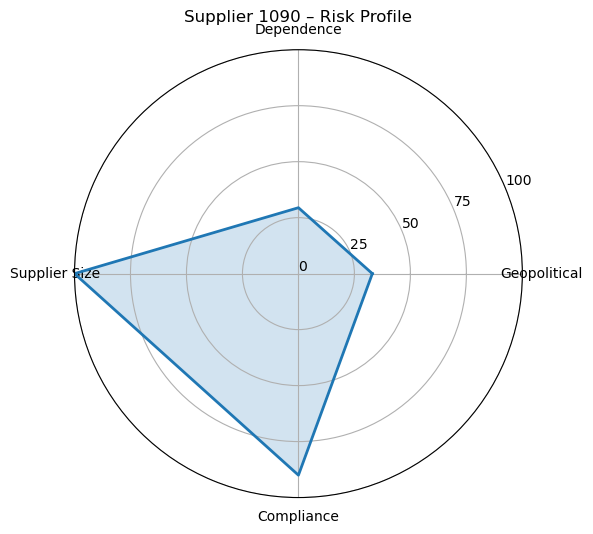

In [12]:
plot_supplier_radar(final_table, supplier_id=1090)